# Forecasting Concurrent Users of PlaiCraft Minecraft Server 

## Introduction

### Relevant backgroud information:

PlaiCraft is a Minecraft server that merges the realms of the popular video game Minecraft and AI research; they collect data to train and better its model programming. As participants of the research and DSCI 100 students, two varying data sets collected from previous participants were provided to us. In this project, we will utilize the knowledge and skills  we learned from this course as students in a real-world application. Upon analysis of the data sets, the following research question poses paths for conceptual application.

  

### Research Question: 
Can the day of the week and the time of day be used to accrately predict the number of concurrent players online using KNN regression?

### Dataset Description



`sessions.csv` contains a list of all playing sessions from April 6 2024 to September 26 2024. There are 1535 observations representing 1535 playing sessions. There are 5 variables:
- `hashedEmail`(Character): The email that the player inputted when registering. This hashed email can help associated user information on `players.csv`
- `start_time`(Character): The start time of the session, in the format dd/mm/yyyy hh:ss 
- `end_time`(Character): The end time of the session, in the format dd/mm/yyyy hh:ss 
- `original_start_time`(Double): The Unix time of the beginning of the playing session, measured in seconds and to 6 significant figures of precision ($\pm$ 115 days).
- `original_end_time`(Double): The Unix time of the beginning of the playing session, measured in seconds and to 6 significant figures of precision ($\pm$ 115 days).



## Methods & Results

loads data 

In [2]:
library(tidyverse)
library(tidymodels)
library(hms)
library(RColorBrewer)

url <- "https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB" # url for download of session.csv
sessions_df <- read_csv(url)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

wrangles and cleans the data to the format necessary for the planned analysis

In [3]:
sessions_df_start_time_end_time <- sessions_df|>
    mutate(start_time = with_tz(as_datetime(dmy_hm(start_time )), tz = "America/Vancouver"))|>
    mutate(end_time = with_tz(as_datetime(dmy_hm(end_time)), tz = "America/Vancouver"))|>
    select(start_time, end_time)|>
    arrange(start_time)|>
    drop_na()

In [4]:
start.min <- min(sessions_df_start_time_end_time$start_time, na.rm=T)
end.max <- max(sessions_df_start_time_end_time$end_time, na.rm=T)
tinterval <- seq.POSIXt(start.min, end.max, by = "mins")

In [5]:
player_count <- sapply(tinterval, function(tt) sum(sessions_df_start_time_end_time$start_time <= tt & tt <= sessions_df_start_time_end_time$end_time))

performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 

In [6]:
session_df_by_minute <- data.frame(tinterval, player_count)|>
        filter(minute(tinterval) == 0 | minute(tinterval) == 30 )|>
        mutate(wday = wday(tinterval))|>
        mutate(as_minutes = 60*hour(tinterval)+minute(tinterval))
                                                     
head(session_df_by_minute)


,tinterval,player_count,wday,as_minutes
,<dttm>,<int>,<dbl>,<dbl>
1,2024-04-06 02:30:00,1,7,150
2,2024-04-06 03:00:00,1,7,180
3,2024-04-06 03:30:00,0,7,210
4,2024-04-06 04:00:00,0,7,240
5,2024-04-06 04:30:00,0,7,270
6,2024-04-06 05:00:00,0,7,300


Visulization of Summary

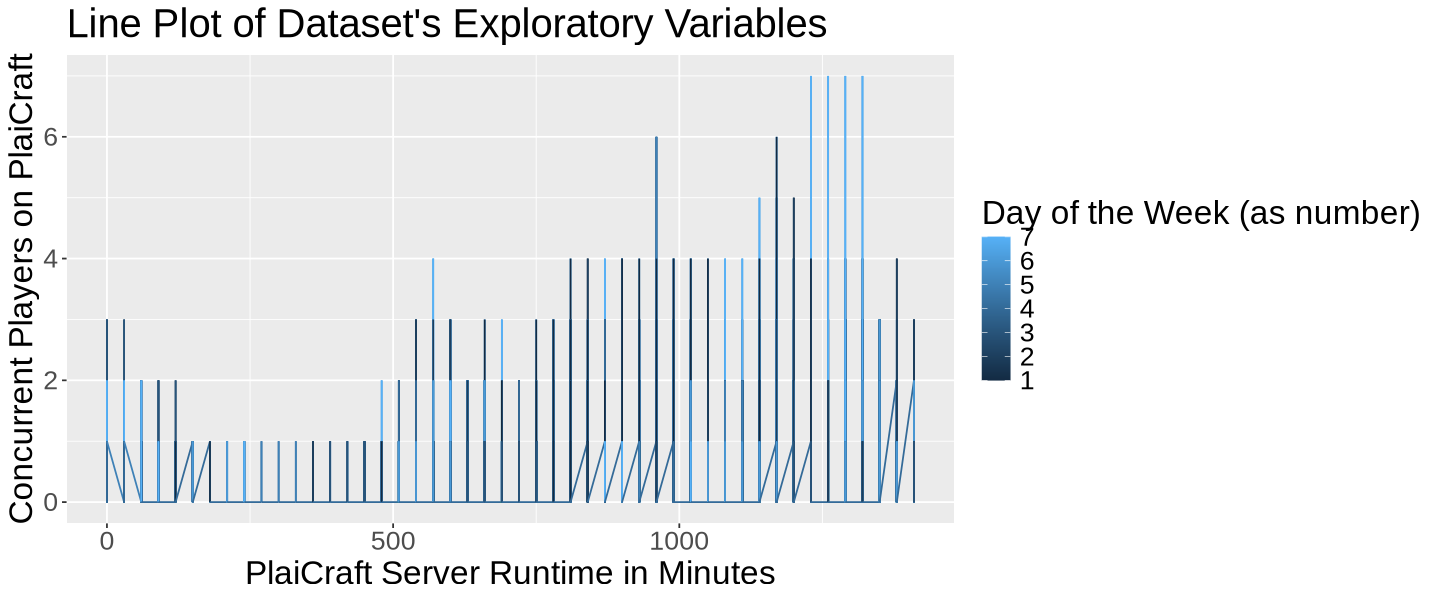

In [7]:
summary_visualization <- session_df_by_minute |>
ggplot(aes(x = as_minutes, y = player_count)) +
geom_line(aes(colour = wday)) +
labs(y = "Concurrent Players on PlaiCraft", x = "PlaiCraft Server Runtime in Minutes",
     colour = "Day of the Week (as number)",
     title = "Line Plot of Dataset's Exploratory Variables") +
theme(text=element_text(size=20))
options(repr.plot.width = 12, repr.plot.height = 5)

summary_visualization

Modeling

In [8]:
set.seed(69420)
# splitting the data into training and testing sets
sessions_split <- initial_split(session_df_by_minute , prop = 0.6 , strata = player_count)
sessions_training <- training(sessions_split)
sessions_testing <- testing(sessions_split)
# knn regression, tune nearest neighbors
sessions_spec <- nearest_neighbor(weight_func = "rectangular" , neighbors = tune()) |> 
      set_engine("kknn") |>
      set_mode("regression")
# predict based on as_minutes and wday
sessions_recipe <- recipe( player_count ~ as_minutes + wday, data = sessions_training) |>
   step_scale(all_predictors()) |>
   step_center(all_predictors())
# workflow
sessions_workflow <- workflow() |>
      add_recipe(sessions_recipe) |>
      add_model(sessions_spec)

In [9]:
# five fold validation
sessions_vfold <- vfold_cv(sessions_training, v = 5, strata = player_count)
# tibble of neighbor values between 1 and 200
gridvals <- tibble(neighbors = seq(1,200, by=1))
# training
training_results <- sessions_workflow |>
                       tune_grid(resamples = sessions_vfold, grid = gridvals) |>
                       collect_metrics() 
# best neightbor values
training_min <- training_results |>
               filter(.metric == 'rmse') |>
               filter(mean == min(mean)) |>
            select( neighbors)|>
            pull()

In [10]:
# engine spec for the best 
session_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = training_min) |>
                  set_engine("kknn") |>
                  set_mode("regression")
# fit model to training data
session_fit <- workflow() |>
           add_recipe(sessions_recipe) |>
           add_model(session_best_spec) |>
           fit(data = sessions_training)

In [11]:
# predict testing data 
session_summary <- session_fit |> 
           predict(sessions_testing) |>
           bind_cols(sessions_testing) |>
           metrics(truth = player_count, estimate = .pred)
session_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,0.6523279
rsq,standard,0.1277348
mae,standard,0.4079209


Visulization of Modeling

In [12]:
# create dataframe with predicted and actual results
compare_df <- session_fit |> 
           predict(sessions_testing) |>
           bind_cols(sessions_testing)|>
            mutate( hms = as_hms(tinterval))|>
     mutate(wday = as_factor(wday(tinterval, label = TRUE)))

head(compare_df)

.pred,tinterval,player_count,wday,as_minutes,hms
<dbl>,<dttm>,<int>,<ord>,<dbl>,<time>
0.071428571,2024-04-06 02:30:00,1,Sat,150,02:30:00
0.044642857,2024-04-06 03:00:00,1,Sat,180,03:00:00
0.008928571,2024-04-06 04:00:00,0,Sat,240,04:00:00
0.035714286,2024-04-06 06:00:00,0,Sat,360,06:00:00
0.446428571,2024-04-06 09:30:00,0,Sat,570,09:30:00
0.428571429,2024-04-06 11:00:00,0,Sat,660,11:00:00


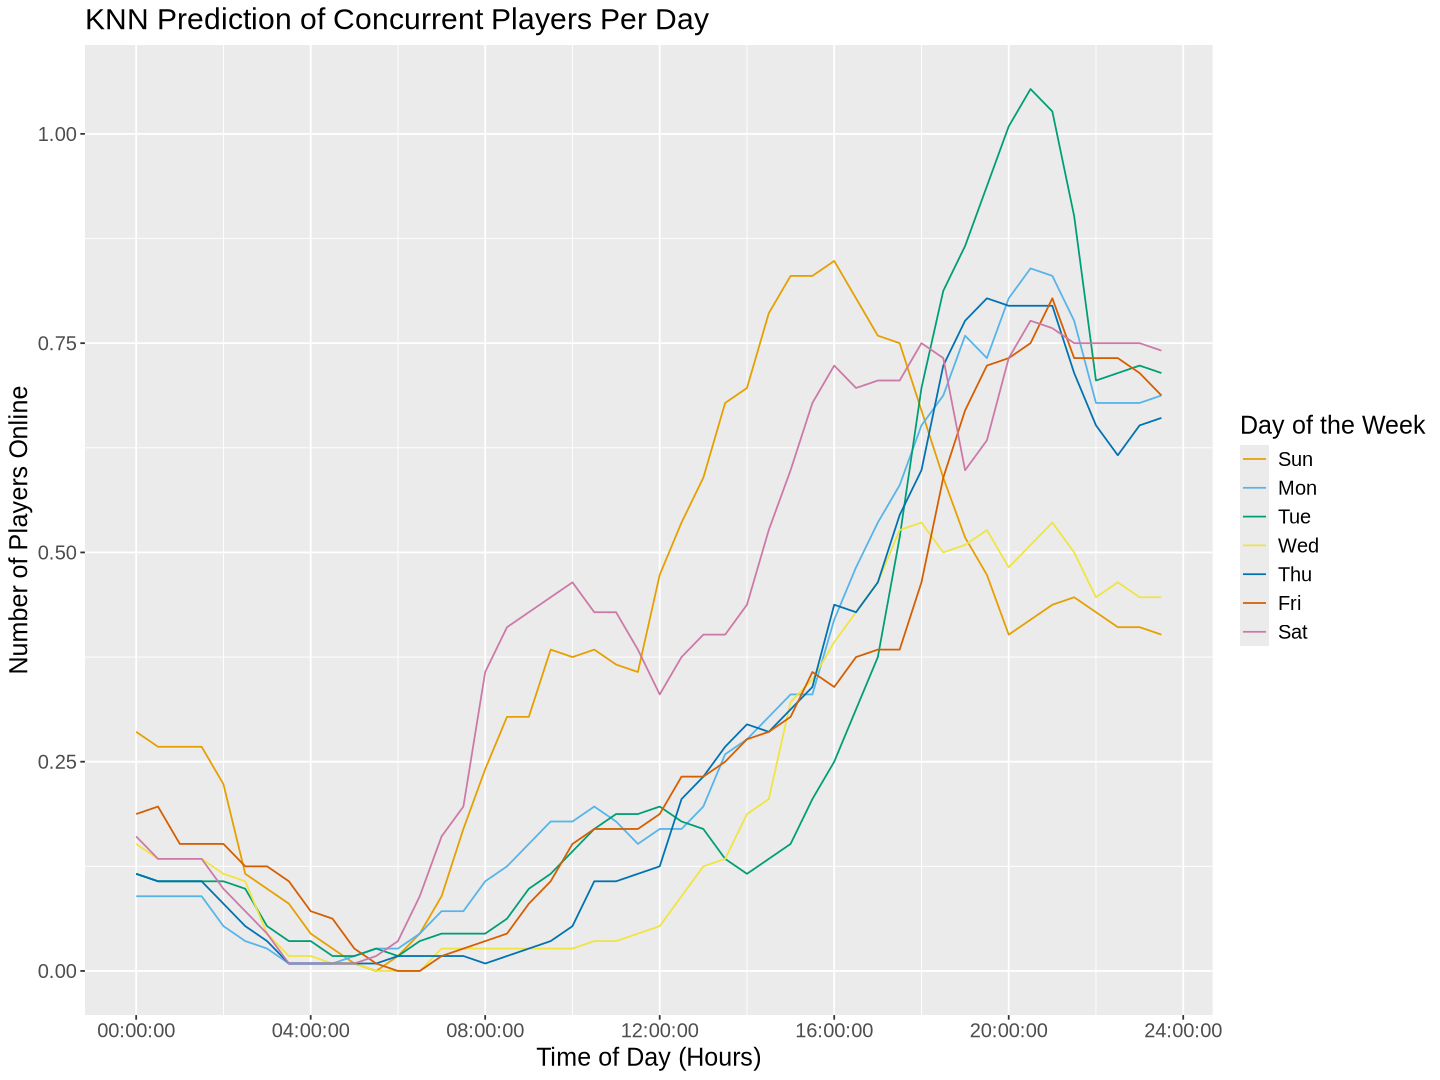

In [13]:
# plot 1
# compare_plot <- compare_df |>
#     ggplot( aes( x = hms, y = player_count))+
#     # geom_point( alpha = 0.1 , colour = "blue")+
#     geom_line( aes( x = hms, y = .pred, colour = as_factor(wday)))+
# labs(x="Time of Day (Hours)", y= "Number of Players Online", colour = "Day of the Week")+
#      ggtitle("KNN Prediction of Concurrent Players Per Day")+

# theme(text=element_text(size=20))
# options(repr.plot.width = 15, repr.plot.height = 10)



compare_plot <- compare_df |> 
  ggplot(aes(x = hms, y = player_count)) +
  geom_line(aes(x = hms, y = .pred, colour = as_factor(wday))) +
  labs(x = "Time of Day (Hours)", y = "Number of Players Online", colour = "Day of the Week") +
  ggtitle("KNN Prediction of Concurrent Players Per Day") +
  theme(text = element_text(size = 15)) +
  scale_colour_manual(
    values = c(
      "Sun" = "#E69F00",  # Orange
      "Mon" = "#56B4E9",  # Sky Blue
      "Tue" = "#009E73",  # Green
      "Wed" = "#F0E442",  # Yellow
      "Thu" = "#0072B2",  # Blue
      "Fri" = "#D55E00",  # Vermilion
      "Sat" = "#CC79A7"   # Pink
        # colours are colourblind friendly using Okabe-Ito pallete
    ))

options(repr.plot.width = 12, repr.plot.height = 9)

compare_plot


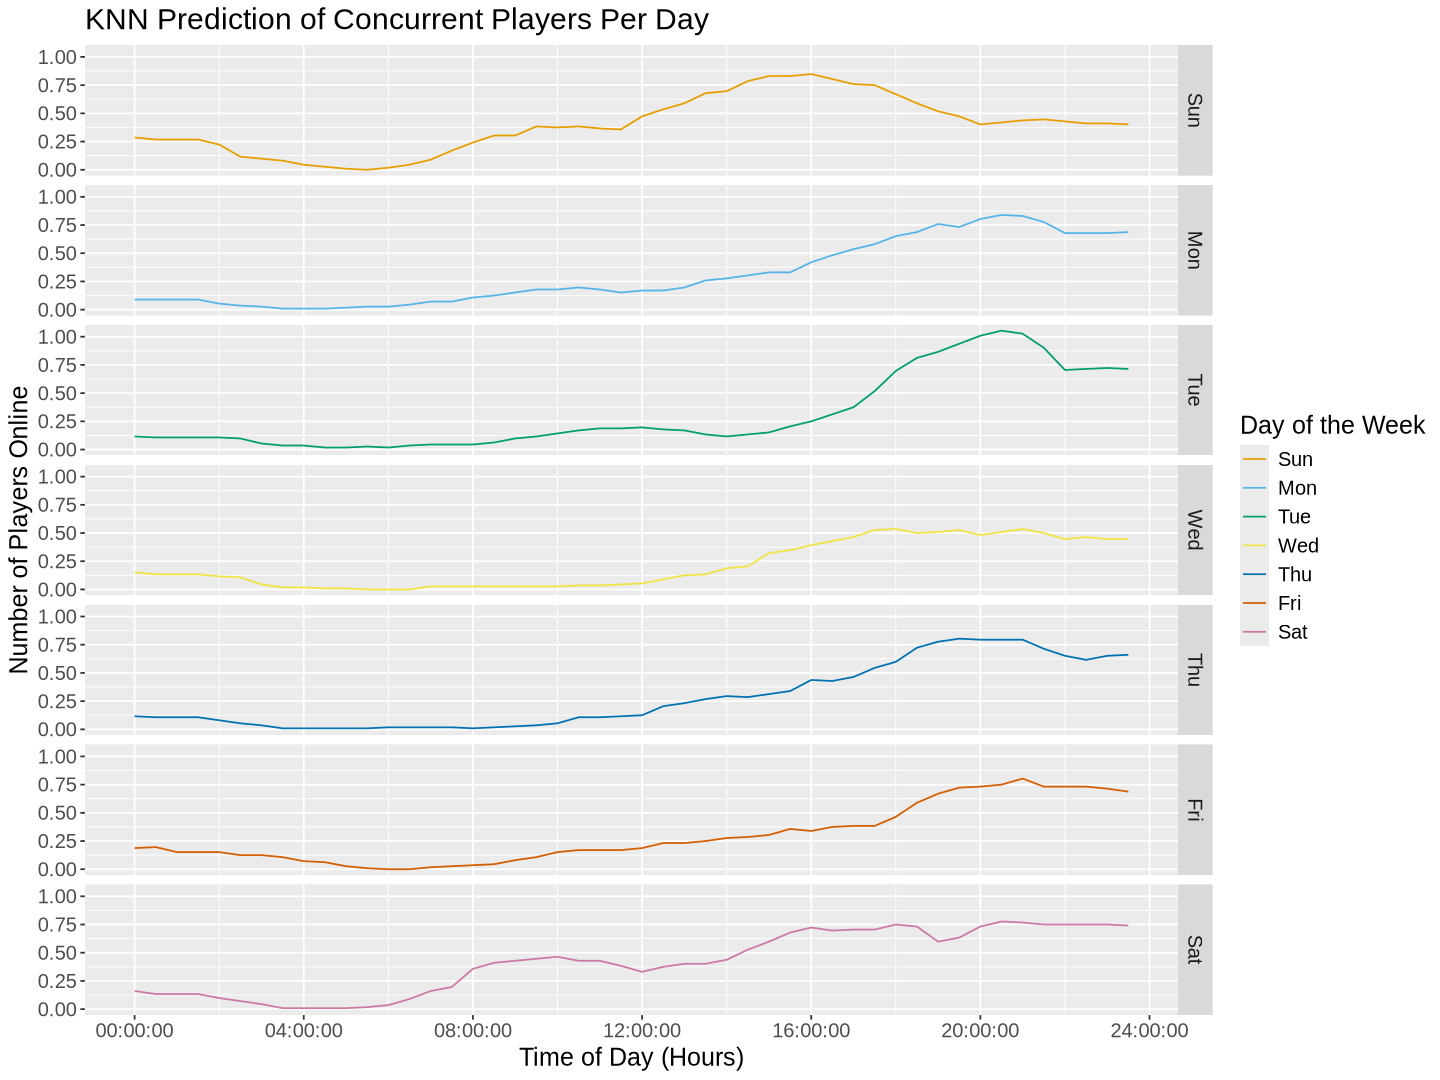

In [20]:
compare_facet_plot <- compare_df|>
ggplot(aes(x-hms, y= player_count)) +
geom_line(aes(x=hms, y= .pred, colour= as_factor(wday))) +
facet_grid(rows =vars(wday))+
 labs(x = "Time of Day (Hours)", y = "Number of Players Online", colour = "Day of the Week") +
  ggtitle("KNN Prediction of Concurrent Players Per Day") +
  theme(text = element_text(size = 15)) +
scale_colour_manual(
    values = c(
      "Sun" = "#E69F00",  # Orange
      "Mon" = "#56B4E9",  # Sky Blue
      "Tue" = "#009E73",  # Green
      "Wed" = "#F0E442",  # Yellow
      "Thu" = "#0072B2",  # Blue
      "Fri" = "#D55E00",  # Vermilion
      "Sat" = "#CC79A7"   # Pink
        # colours are colourblind friendly using Okabe-Ito pallete
    ))
options(repr.plot.width = 12, repr.plot.height = 9)

compare_facet_plot

## Discussion

summarize what you found

-discuss whether this is what you expected to find?

-discuss what impact could such findings have?

-discuss what future questions could this lead to?

### Summary:

Could this data have been better?